Clustering
==========
Clustering is a type of unsupervised learning. It is the task of grouping together a set of objects in a way that objects in the same group (cluster) are more similar to each other than to those in other groups.

K-means Clustering
--------------------
K-means algorithm has two steps:
1. An initial guess for the cluster centroids is made.
2. The algorithm iterates between two steps:
3. Assign each data point to the nearest cluster centroid.
4. Compute the new cluster centroids by averaging all the data points assigned to each cluster.
5. Repeat steps 3 and 4 until the cluster centroids do not change significantly.

K-means Algorithm
--------------------
- Randomly initialize K cluster centroids.
- Repeat {
- * assign points to the nearest cluster centroid
- for i = 1 to m
-   c(i) := index (from 1 to K) of cluster centroid closest to x(i)   ---> min(k) ||x(i) - u(k)||^2  --> L2 norm
- * move cluster centroids to the average of the points assigned to them
- for k = 1 to K
-   u(k) := average (mean) of points assigned to cluster k
- }

What happens if a cluster centroid ends up with no points assigned to it? One way to handle this is to randomly reinitialize the cluster centroid. Another way is to eliminate the cluster and reduce K by one.

It turns out that K-means is frequently applied to datapoints that are not well separated.

K-means Optimization Objective
-------------------------------
c(i) = index of cluster (1, 2, ..., K) to which example x(i) is currently assigned
μk = cluster centroid k
μc(i) = cluster centroid of cluster to which example x(i) has been assigned

The cost function is then:
J(c(1), ..., c(m), μ1, ..., μK) = 1/m ∑||x(i) - μc(i)||^2
It is trying to minimize the sum of the squared differences between each datapoint and the cluster centroid to which it has been assigned.
It is also called the distortion function.

So, the K-means algorithm is trying to solve the following optimization problem:
minimize J(c(1), ..., c(m), μ1, ..., μK)

If after some iterations, the cost function is not decreasing, then the algorithm has converged.
If the cost is increasing, then the algorithm is not working correctly.

K-means initialization
-----------------------
K-means is not guaranteed to converge to the global minimum. It may converge to a local minimum depending on the initialization of the cluster centroids.
To mitigate this, the algorithm is often run multiple times with different random initializations.
- Choose k < m (where m is the number of training examples)
- Randomly pick k training examples
- Set μ1, μ2, ..., μk equal to these k examples
- Run K-means. Repeat multiple times and pick clustering that gives the lowest cost.
- Usually run K-means 50-1000 times with different random initializations.

Choosing the Number of Clusters
-------------------------------
Elbow Method:
- Choose the number of clusters that gives the lowest distortion (cost function).
- Plot the cost function as a function of the number of clusters (k).
- The cost function decreases as the number of clusters increases.
- The cost function decreases less rapidly as the number of clusters increases.
- Choose the number of clusters at the "elbow" point.
- The elbow is the point where the cost function starts to decrease less rapidly.

But remember that for a lot of applications it is not clear what the "correct" number of clusters should be.
And it often happens that there is no elbow point in the plot and the cost just decreases smoothly.

Note: Don't choose K just to minimize the cost function. The cost function will always decrease as K increases.

So how do you choose K?
Often, you choose K based on some other criteria that are specific to your application.
Evaluate K-means based on how well it performs on that specific criterion.
For example, for t-shirt sizing, you might have 3 (s, m, l) or 5 (xs, s, m, l, xl) sizes.

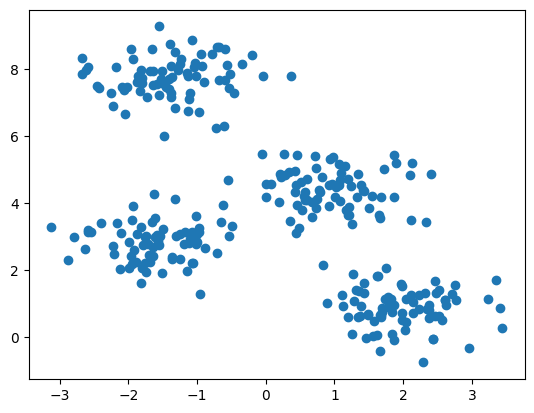

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


# Generate sample data
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [2]:
def kmeans(X, k, max_iters=100):
    m, n = X.shape
    centroids = X[np.random.choice(m, k, replace=False)]
    history = []
    
    for _ in range(max_iters):
        # Cluster assignment step
        c = np.argmin(np.linalg.norm(X[:, None] - centroids, axis=2), axis=1)
        
        # Move centroids step with empty cluster check
        new_centroids = []
        for i in range(k):
            points_in_cluster = X[c == i]
            if len(points_in_cluster) == 0:
                # If no points are assigned, randomly reinitialize the centroid
                new_centroids.append(X[np.random.choice(m)])
            else:
                new_centroids.append(points_in_cluster.mean(axis=0))
        
        new_centroids = np.array(new_centroids)
        
        # Update history
        history.append((c, centroids))
        
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        
    return c, centroids, history

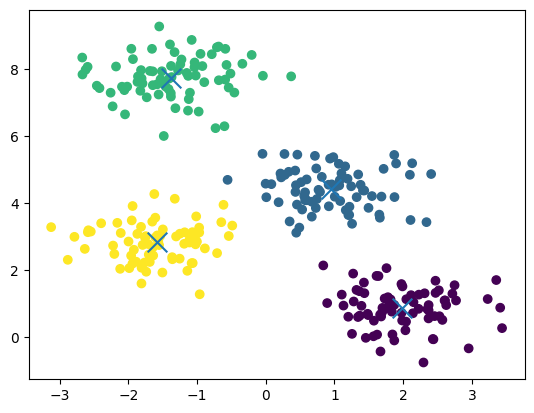

In [9]:
c, centroids, history = kmeans(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='x')
plt.show()

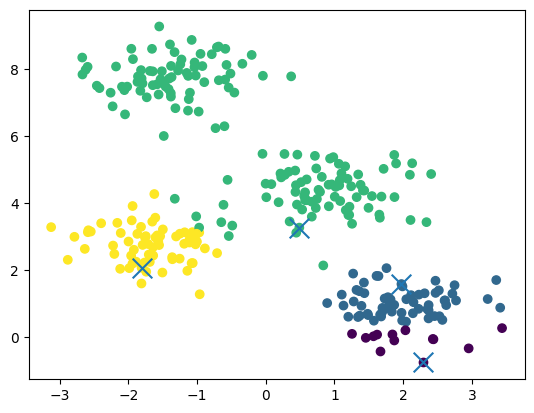

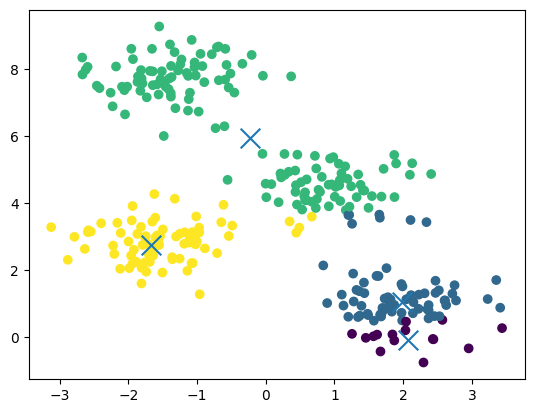

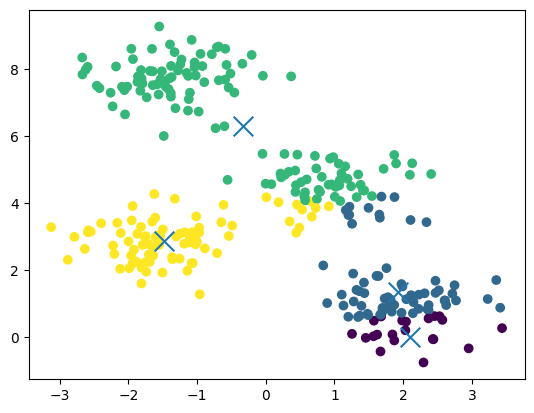

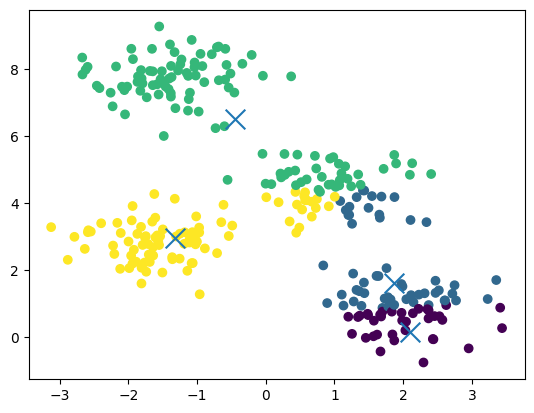

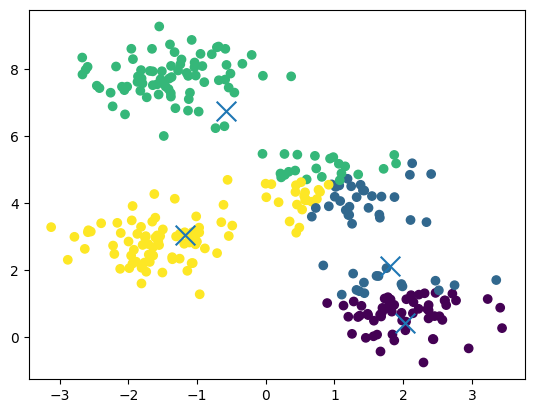

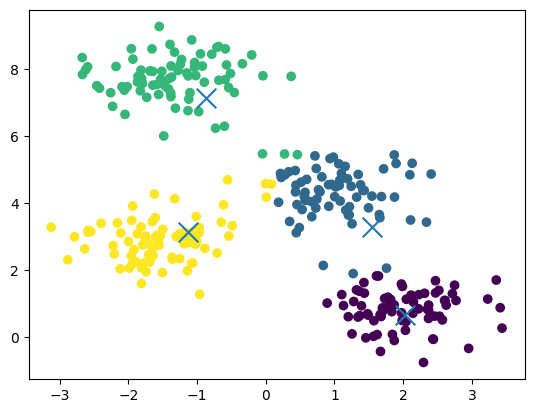

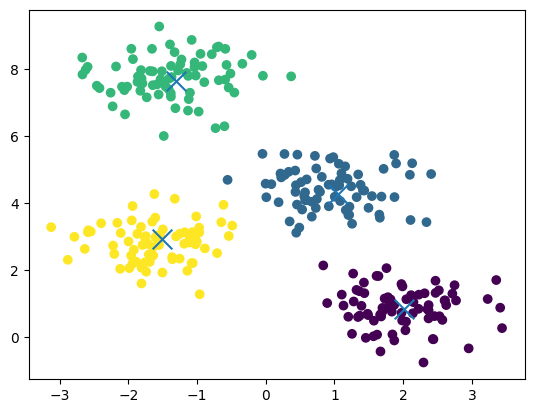

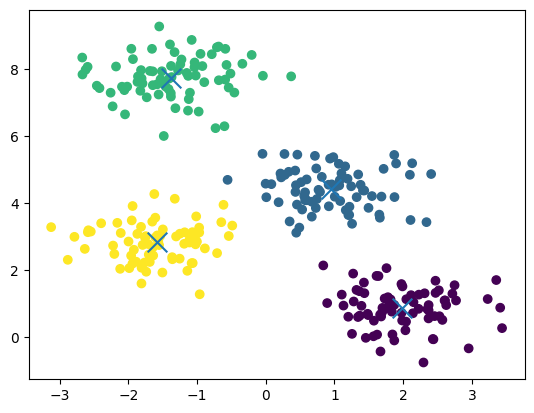

In [15]:
def plot_history(X, history):
    for c, centroids in history:
        plt.scatter(X[:, 0], X[:, 1], c=c)
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='x')
        plt.pause(0.5)
        plt.show()
        
plot_history(X, history)

Image Compression with K-means
-------------------------------
- In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as the RGB encoding.
- Our image contains thousands of colors, and here, we will reduce the number of colors to 16 colors.
- By making this reduction, it is possible to represent (compress) the photo in an efficient way.
- Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image we now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

we will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.

- Concretely, we will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space.
- Once we have computed the cluster centroids on the image, we will then use the 16 colors to replace the pixels in the original image.

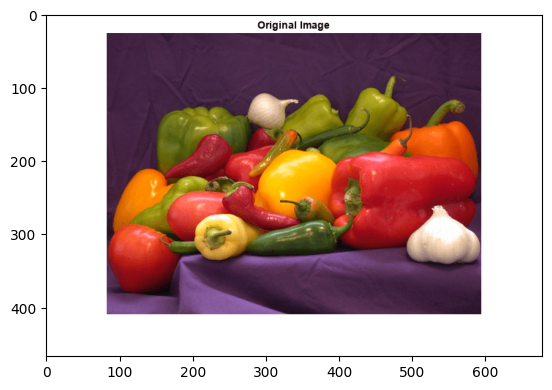

In [3]:
# load the image
import cv2
original_img = cv2.imread('image.jpg')
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.imshow(original_img)

In [4]:
print(original_img.shape)

(467, 678, 3)


In [5]:
# divide by 255 so that all values are in the range 0 - 1
original_img = original_img / 255

# reshape the image to an m x 3 matrix where m = number of pixels
X = original_img.reshape(-1, 3)

In [6]:
c, centroids, history = kmeans(X, 16)

In [7]:
print(centroids)

[[0.8711698  0.70931452 0.57134061]
 [0.94152597 0.31932912 0.26746164]
 [0.49949434 0.33626132 0.55276472]
 [0.87009353 0.70439822 0.28519241]
 [0.19745591 0.08659562 0.16345673]
 [0.35891524 0.34963739 0.080252  ]
 [0.6238387  0.55715981 0.12976054]
 [0.97244852 0.88750181 0.78474666]
 [0.33131031 0.18926892 0.32515536]
 [0.99994114 0.99992642 0.99982341]
 [0.5475131  0.07393071 0.09534749]
 [0.21287781 0.20560764 0.06575263]
 [0.47972184 0.45256428 0.10819432]
 [0.97544416 0.5609792  0.01750117]
 [0.76790023 0.18198816 0.1224561 ]
 [0.26477177 0.14305201 0.25807618]]


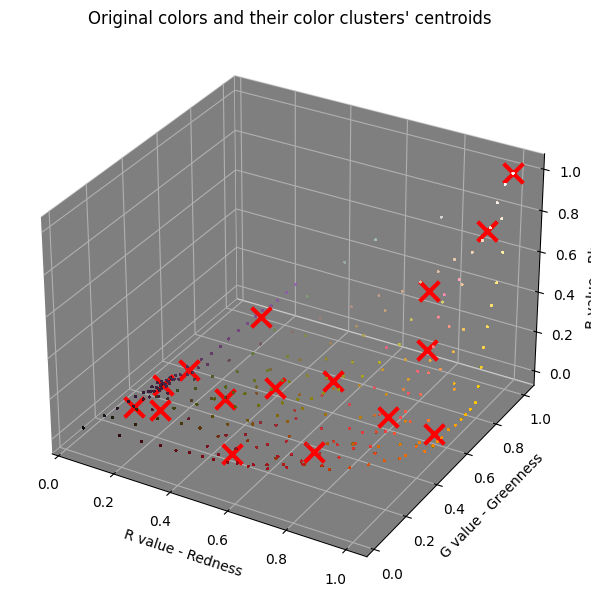

In [11]:
# plot the centroids and all the colors in a 3D plot of RGB
def plot_kMeans_RGB(X, centroids, idx, K):
    # Plot the colors and centroids in a 3D space
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(221, projection='3d')
    
    # Normalize RGB values between 0 and 1 for matplotlib
    # X_normalized = X / 255.0
    # centroids_normalized = centroids / 255.0
    
    # Plot the color points
    ax.scatter(*X.T, zdir='z', depthshade=False, s=0.3, c=X)
    
    # Plot the centroids
    ax.scatter(*centroids.T, zdir='z', depthshade=False, s=200, c='red', marker='x', lw=3)
    
    ax.set_xlabel('R value - Redness')
    ax.set_ylabel('G value - Greenness')
    ax.set_zlabel('B value - Blueness')
    
    # Set pane colors for clarity
    ax.xaxis.pane.set_facecolor((0., 0., 0., .2))
    ax.yaxis.pane.set_facecolor((0., 0., 0., .2))
    ax.zaxis.pane.set_facecolor((0., 0., 0., .2))
    
    ax.set_title("Original colors and their color clusters' centroids")
    plt.show()
    
plot_kMeans_RGB(X, centroids, c, 16)

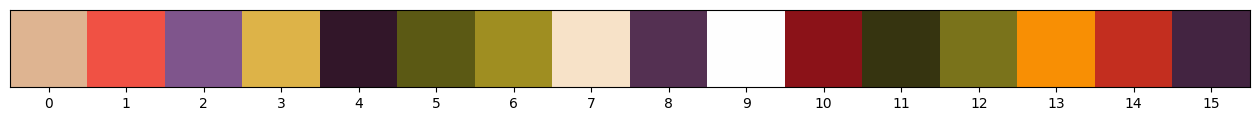

In [10]:
# visualize the 16 colors that we have chosen
palette = np.expand_dims(centroids, axis=0)
num = np.arange(0,len(centroids))
plt.figure(figsize=(16, 16))
plt.xticks(num)
plt.yticks([])
plt.imshow(palette)

After finding the top 𝐾=16 colors to represent the image, you can now assign each pixel position to its closest centroid.

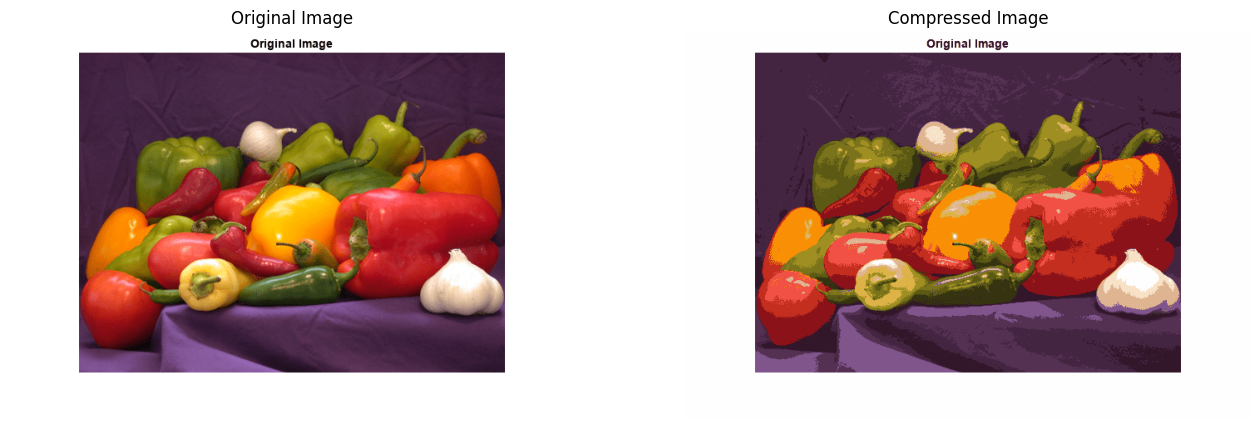

In [13]:
# compressing the image by assigning each pixel to the closest centroid
# plot the original and the reconstructed image
def compress_image(X, centroids, c):
    X_compressed = centroids[c]
    X_compressed = X_compressed.reshape(original_img.shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 16))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(X_compressed)
    ax[1].set_title('Compressed Image')
    ax[1].axis('off')
    
    plt.show()

compress_image(X, centroids, c)

Anomaly Detection
=================
Anomaly detection is the identification of rare items, events, or observations that raise suspicions by differing significantly from the majority of the data. Typically, the anomalous items will translate to some kind of problem such as bank fraud, a structural defect, medical problems, or errors in a text.
- Density Estimation: Anomaly detection is often done by modeling the distribution of the data and identifying instances that do not fit the model. It will go by modeling the probability of the data and then finding the regions where the probability is high, and those where it is low.
- So when a new x(test) is given, if p(x(test)) < ε, then it is an anomaly.

Gaussian (Normal) Distribution
-------------------------------
- If x is a number, then the probability of x is determined by a Gaussian with mean μ and variance σ^2.
- The Gaussian distribution can be interpreted as, if you plot a histogram of x, it will have a bell shape; and on an infinite number line, it will be symmetric around μ.
- p(x) = (1 / sqrt(2πσ^2)) * exp(-((x - μ)^2) / 2σ^2)
- Because probabilities must sum up to 1, the area under the Gaussian curve is 1.
- Given the dataset, we can estimate the parameters μ and σ^2.
- μ = (1 / m) * ∑x(i) --> mean
- σ^2 = (1 / m) * ∑(x(i) - μ)^2 --> variance

How does the curve change if we change μ or σ^2?
- μ determines the center of the curve.
- σ^2 determines the width of the curve.

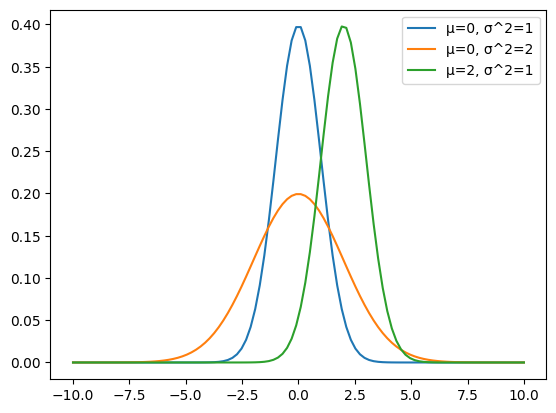

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def gaussian_distribution(x, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))


x = np.linspace(-10, 10, 100)
y1 = gaussian_distribution(x, 0, 1)
y2 = gaussian_distribution(x, 0, 2)
y3 = gaussian_distribution(x, 2, 1)

plt.plot(x, y1, label='μ=0, σ^2=1')
plt.plot(x, y2, label='μ=0, σ^2=2')
plt.plot(x, y3, label='μ=2, σ^2=1')
plt.legend()
plt.show()

Anomaly Detection Algorithm
----------------------------
In practice, x is usually a vector and not a single number.
- Suppose each example x(i) has n features.
- p(x) = p(x1; μ1, σ1^2) * p(x2; μ2, σ2^2) * ... * p(xn; μn, σn^2)
- Note: the formula above is usually used for cases where probabilities are independent, but the algorithm often works fine even if they are not.

So the algorithm is:
1. Choose n features x(i) that you think might be indicative of anomalous examples.
2. Fit parameters μ1, ..., μn, σ1^2, ..., σn^2.
3. Given a new example x, compute p(x):
   p(x) = p(x1; μ1, σ1^2) * p(x2; μ2, σ2^2) * ... * p(xn; μn, σn^2) ;where p(x(i); μi, σi^2) = (1 / sqrt(2πσi^2)) * exp(-((x(i) - μi)^2) / 2σi^2)
4. Anomaly if p(x) < ε.

Note: this algorithm works because even if one probability is low, the entire probability will be low.

Developing and Evaluating an Anomaly Detection System
-----------------------------------------------------
When developing a model, it's helpful if we have a number indicating the algorithm got better or worse.
In other words, making decisions is much easier if we can quantify how well the model is doing.
Assume we have some labeled data, of which some are anomalies and some are not.
- Training set: x(1), x(2), ..., x(m) (assume no anomalies)
- Cross-validation set: xval(1), xval(2), ..., xval(m) (a few anomalies)
- Test set: xtest(1), xtest(2), ..., xtest(m) (a few anomalies)
Note: in practice the algorithm will usually work even if there are some actual anomalies in the training set.

For example:
- Training set: 6000 normal engines
- Cross-validation set: 2000 normal engines, 10 faulty engines
- Test set: 2000 normal engines, 10 faulty engines

Use cross-validation set to choose parameter ε and tune features, and use test set to estimate how well the algorithm is doing.

Alternative: No test set -> 4000 normal engins, 20 faulty engines in cross-validation set.
This alternative makes sense when you have really few anomalies.
But the downside is that you won't have a fair way to estimate how well the algorithm is doing. -> higher risk of over-fitting

Possible alternatives for evaluation metrics:
- True positive, false positive, false negative, true negative
- Precision/recall
- F1 score
